# NBA Clustering based on advanced stats

## Importing stats:

In [1005]:
shooting_names = ['Player', 'Team', 'AGE', 'FGM LESS THAN 5FT.', 'FGA LESS THAN 5FT.',\
       'FG% LESS THAN 5FT.', 'FGM 5-9 FT.', 'FGA 5-9 FT.', 'FG% 5-9 FT.',\
       'FGM 10-14 FT.', 'FGA 10-14 FT.', 'FG% 10-14 FT.', 'FGM 15-19 FT.',\
       'FGA 15-19 FT.', 'FG% 15-19 FT.', 'FGM 20-24 FT.', 'FGA 20-24 FT.',\
       'FG% 20-24 FT.', 'FGM 25-29 FT.', 'FGA 25-29 FT.', 'FG% 25-29 FT.']
passing_names = ['Player', 'Team', 'PASSES MADE', 'PASSES RECEIVED', 'SECONDARY AST',\
       'POTENTIAL AST', 'AST ADJ', 'AST to PASS% ADJ']
drives_names = ['PLAYER', 'TEAM', 'DRIVES']
touches_names = ['PLAYER', 'TEAM', 'TOUCHES', 'FRONT CT TOUCHES', 'TIME OF POSS',\
       'AVG SEC PER TOUCH', 'AVG DRIB PER TOUCH', 'PTS PER TOUCH',\
       'ELBOW TOUCHES', 'POST UPS', 'PAINT TOUCHES', 'PTS PER ELBOW TOUCH',\
       'PTS PER POST TOUCH', 'PTS PER PAINT TOUCH']
speed_names = ['PLAYER', 'TEAM', 'DIST. FEET', 'DIST. MILES', 'DIST. MILES OFF',\
       'DIST. MILES DEF', 'AVG SPEED', 'AVG SPEED OFF', 'AVG SPEED DEF']

In [1072]:
import pandas as pd
#reading in all the data
stats = pd.read_csv("NBA_stats_BR.csv").drop(["Unnamed: 19", "Unnamed: 24", "Pos", "Age", "Rk",], axis = 1)
stats.Player = stats.Player.replace(regex = r"\\.+",value ="")
stats = stats.set_index(["Player"])
totals = pd.read_csv("NBA_totals_BR.csv").drop(["Rk", "Age", "G", "MP"], axis=1)
totals.Player = totals.Player.replace(regex = r"\\.+",value ="")
totals = totals.set_index(["Player"])
pos = totals.Pos
shooting = pd.read_csv("shooting_zones_NBA.csv", names = shooting_names).drop(["AGE"], axis =1).set_index(["Player"])
passing = pd.read_csv("passing_NBA.csv", names = passing_names).set_index(["Player"])
drives = pd.read_csv("Drives_NBA.csv", names = drives_names).set_index(["PLAYER"])
touches = pd.read_csv("touches_NBA.csv", names = touches_names).set_index(["PLAYER"])
speed = pd.read_csv("speed_NBA.csv", names = speed_names).set_index(["PLAYER"])

#merging everything into 1 table
merged = pd.merge(stats,totals, left_index=True, right_index=True, how = "inner")
merged = pd.merge(merged,shooting, left_index=True, right_index=True, how = "left")
merged = pd.merge(merged,passing, left_index=True, right_index=True, how = "left")
merged = pd.merge(merged,drives, left_index=True, right_index=True, how = "left")
merged = pd.merge(merged,touches, left_index=True, right_index=True, how = "left")
merged = pd.merge(merged,speed, left_index=True, right_index=True, how = "left")

#filtering out players that didn't play much
merged = merged[(merged.G>41)&(merged.MP>1000)]
#dropping irrelevant fields
merged = merged.drop(["GS","Pos", "G", "MP", "TS%", "Tm_y", "Tm_x", "Team_x", "Team_y", "TEAM_x", "TEAM_y", "TEAM"],axis=1)
merged = merged[["3PAr","FTr","ORB%", "DRB%", "AST%","STL%","BLK%", "USG%","OBPM","DBPM", "3P%", "2P%", 'FG% LESS THAN 5FT.','FG% 5-9 FT.', 'FG% 10-14 FT.','FG% 15-19 FT.', 'FG% 20-24 FT.', 'FG% 25-29 FT.', "PASSES MADE", "PASSES RECEIVED", "SECONDARY AST",\
                'AST to PASS% ADJ','DRIVES', 'TOUCHES','FRONT CT TOUCHES', 'AVG SEC PER TOUCH','AVG DRIB PER TOUCH', 'PTS PER TOUCH', 'ELBOW TOUCHES', 'POST UPS',\
       'PAINT TOUCHES','PTS PER ELBOW TOUCH', 'PTS PER POST TOUCH','PTS PER PAINT TOUCH', 'DIST. MILES OFF', 'DIST. MILES DEF','AVG SPEED', 'AVG SPEED OFF', 'AVG SPEED DEF' ]]
#Feature Engineering
merged['POST UP %'] = merged['POST UPS'].astype(float)/merged['TOUCHES'].astype(float)
merged['FRONT CT TOUCH %'] = merged['FRONT CT TOUCHES'].astype(float)/merged['TOUCHES'].astype(float)
merged['PAINT TOUCH %'] = merged['PAINT TOUCHES'].astype(float)/merged['TOUCHES'].astype(float)
merged['ELBOW TOUCH %'] = merged['ELBOW TOUCHES'].astype(float)/merged['TOUCHES'].astype(float)
merged['SPEED DIFF'] = merged['AVG SPEED OFF'].astype(float)-merged['AVG SPEED DEF'].astype(float)
merged['MILES DIFF'] = merged['DIST. MILES OFF'].astype(float)-merged['DIST. MILES DEF'].astype(float)
merged = merged.dropna().drop(['TOUCHES','FRONT CT TOUCHES', 'PAINT TOUCHES', 'ELBOW TOUCHES',"POST UPS", 'AVG SPEED DEF', 'AVG SPEED OFF', 'DIST. MILES OFF', 'DIST. MILES DEF'], axis =1)
merged.shape

(263, 36)

In [1064]:
#normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data = scaler.fit_transform(merged)
norm_stats = pd.DataFrame(Data, index = merged.index, columns = merged.columns)

## Principal Components Analysis:

[ 0.34205224  0.16639657  0.08920389  0.05354815  0.04505213  0.03597322
  0.0306618   0.02554099  0.02210349  0.018953    0.01639237  0.01514598
  0.01466024  0.01377784]
Percent of variance explained by all components: 0.889461922761


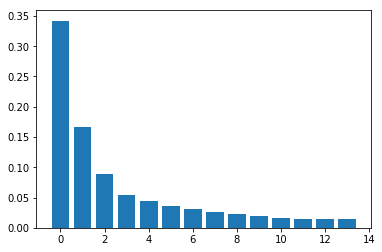

In [1073]:
#Using PCA to identify components
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=14)
pca.fit(norm_stats)
print("pca.explained_variance_ratio_)
print("Percent of variance explained by all components:", sum(pca.explained_variance_ratio_))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
results = pd.DataFrame(index = norm_stats.index)
PC = pd.DataFrame()
for i, component in enumerate(pca.components_):
    top_idx = np.argsort(np.absolute(component))[-15:]
    cols = np.flip(np.array(norm_stats.columns).take(top_idx),axis=0)
    x = np.flip(component.take(top_idx), axis=0)
    PC["PC"+str(i)] = cols+x.astype(str)
    results["PC"+str(i)]=np.dot(norm_stats, component)

In [1078]:
#Recording the top and bottom players for each component
def top(x, k=30):
    return x.sort_values()[-k:].index
def bottom(x, k=10):
    return x.sort_values()[:k].index
def common(x):
    #print(pos[x].value_counts())
    #PC_Pos[] = pos[x].value_counts()[:3].index
    return (pos[x].value_counts()[:2].index)+"-("+pos[x].value_counts()[:2].astype(str)+")"
top10 = results.apply(top)
bot10 = results.apply(bottom)
print("Breaking down each PC by top 2 positions")
print(top10.apply(common))
#Number of players in each position
print("No. of players per position in my dataset:")
print(pos.value_counts())



Breaking down each PC by top 2 positions
       PC0     PC1      PC2      PC3     PC4     PC5      PC6     PC7  \
0  PG-(27)  C-(24)  SG-(16)  PF-(16)  C-(11)  PG-(9)  PG-(11)   C-(9)   
1   SG-(3)  PF-(3)   SF-(4)   C-(10)  SF-(8)  PF-(7)    C-(7)  SG-(8)   

       PC8     PC9    PC10     PC11    PC12    PC13  
0  PF-(13)  PG-(8)  SG-(8)  PF-(11)  SG-(8)  PG-(8)  
1   SG-(5)  SF-(8)  PF-(7)   PG-(8)  PF-(8)  SG-(8)  
No. of players per position in my dataset:
SG       128
PG       111
PF       105
C        105
SF        88
SF-SG      2
PG-SG      1
Name: Pos, dtype: int64


In [1080]:
print("Top attributes in each principal component")
PC

Top attributes in each principal component


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,AVG DRIB PER TOUCH0.3896089269111345,3PAr-0.38037285457560766,PTS PER TOUCH0.5365511472267239,SPEED DIFF0.3804179024145886,AVG SPEED-0.4519679502862689,STL%-0.4622692137250154,FG% 10-14 FT.0.38676764631731897,FTr-0.3353429469558664,PTS PER ELBOW TOUCH0.5551450847767633,FG% 10-14 FT.-0.40928566943212075,PTS PER POST TOUCH0.37050751473254406,FG% 5-9 FT.0.41657481444558814,FG% 20-24 FT.-0.36525869952953616,FG% 15-19 FT.0.6295399489808511
1,AVG SEC PER TOUCH0.35460239546790145,ORB%0.29108990150752634,FRONT CT TOUCH %0.3346504995610037,PASSES MADE0.341953529563124,SPEED DIFF-0.39884545936544713,2P%-0.387346337897609,FG% 5-9 FT.0.2975135865852568,STL%0.3222184347929057,FRONT CT TOUCH %-0.4292821617791161,FTr-0.3242269367503006,FG% 20-24 FT.-0.342334348187238,FG% 10-14 FT.-0.41421490674658634,SPEED DIFF0.3379506856183111,FG% 10-14 FT.-0.49552160858240873
2,PASSES RECEIVED0.29310584829396175,DRB%0.28273533133628187,USG%0.3307796862204245,MILES DIFF0.3402418305712991,2P%-0.3141620925609158,FG% LESS THAN 5FT.-0.3434363753136289,FTr-0.26408938990941366,FG% 20-24 FT.0.3190688063115752,AST to PASS% ADJ-0.3128680741867601,FG% 15-19 FT.-0.2719945528048873,FG% LESS THAN 5FT.-0.3143960926514583,PTS PER ELBOW TOUCH-0.3885942882628531,BLK%0.3168946794433749,PTS PER POST TOUCH0.3846391828964436
3,DRIVES0.2767271655493329,FTr0.25673880664923476,PTS PER ELBOW TOUCH0.2681595464966448,AST to PASS% ADJ-0.2710722664765388,PTS PER ELBOW TOUCH-0.28559129409515926,DBPM-0.32223116089569337,FG% 15-19 FT.0.2617127008665123,FG% 15-19 FT.0.3140710306931651,SPEED DIFF-0.2551698639444662,PTS PER ELBOW TOUCH0.25842924403693596,BLK%-0.2924193546575675,FRONT CT TOUCH %-0.23936043119483374,ORB%-0.31631176220814433,FG% 5-9 FT.-0.19436352675007626
4,AST%0.25088560279021505,BLK%0.2565869501878895,OBPM0.26224684148749955,3PAr0.2531791595628095,3PAr0.24849632777588093,3PAr-0.2826946307691442,SPEED DIFF-0.2513630103555769,FG% 5-9 FT.0.3043856404475575,AVG SPEED-0.25481160879607495,STL%-0.2332693856777045,FG% 5-9 FT.0.28468522306622845,PTS PER POST TOUCH0.23256890279134776,FG% 5-9 FT.0.2868808527813461,FG% LESS THAN 5FT.0.1520888849940848
5,AST to PASS% ADJ0.2382076703568228,PASSES MADE0.25217455992138765,PTS PER PAINT TOUCH0.24799040500525252,AVG DRIB PER TOUCH-0.23780781760296377,FG% 10-14 FT.-0.22632493652310418,OBPM-0.25994192757018114,STL%-0.2457434852554341,DBPM0.2963767939475792,ELBOW TOUCH %-0.23012474101072714,FG% LESS THAN 5FT.0.23206192673312087,STL%0.28110095410136104,PTS PER PAINT TOUCH0.22191641711700633,PAINT TOUCH %-0.22347497284668505,FRONT CT TOUCH %-0.13894082113704906
6,FRONT CT TOUCH %-0.2089034079559448,PASSES RECEIVED0.21726773848308334,FG% LESS THAN 5FT.0.18188553411505384,PTS PER TOUCH-0.23346884789450717,POST UP %0.19828925102562367,USG%0.2093059140593463,2P%0.24505608779993376,3PAr-0.2931479723372909,PTS PER PAINT TOUCH0.17102527612233323,FG% 20-24 FT.-0.21647282143477464,FG% 10-14 FT.0.22783451293869675,AST to PASS% ADJ-0.22180737808234774,OBPM-0.21594823072083452,PTS PER ELBOW TOUCH0.135314985532814
7,SECONDARY AST0.20448185142058198,USG%0.21719719323882067,FG% 20-24 FT.0.14520532483551984,STL%-0.23251971032529217,FG% LESS THAN 5FT.-0.19300918126651617,POST UP %0.2052805560243453,PTS PER ELBOW TOUCH-0.23979109301471593,AVG SPEED0.2825358641067339,DRB%0.17089395594357573,PTS PER TOUCH-0.1986951473499456,ORB%0.21185433560154548,FG% 15-19 FT.-0.19320868471883937,ELBOW TOUCH %-0.1962116298368586,DRIVES-0.1206045767204541
8,ORB%-0.20239206850574565,DBPM0.21102864501798568,DBPM-0.13920709006118479,DRB%0.2171644249980651,FG% 5-9 FT.-0.1762852887143624,MILES DIFF0.18529791917611516,FG% LESS THAN 5FT.0.2396634873005481,OBPM-0.22125250116026288,MILES DIFF-0.16487811050540052,BLK%-0.19728482266622716,OBPM0.21012925677369232,FG% 25-29 FT.0.17887771143946374,3P%-0.1837909877811395,SPEED DIFF0.11753136668411712
9,PASSES MADE0.1951198928864262,ELBOW TOUCH %0.20390268845774456,FG% 15-19 FT.0.130801

## Clustering based on reduced dimensions: (KMeans)

For n_clusters = 2 The average silhouette_score is : 0.262284650232
For n_clusters = 3 The average silhouette_score is : 0.239767374928
For n_clusters = 4 The average silhouette_score is : 0.190962791776
For n_clusters = 5 The average silhouette_score is : 0.159260357018
For n_clusters = 6 The average silhouette_score is : 0.152187796854
For n_clusters = 7 The average silhouette_score is : 0.139453047906
For n_clusters = 8 The average silhouette_score is : 0.14767625113
For n_clusters = 9 The average silhouette_score is : 0.132703586403
For n_clusters = 10 The average silhouette_score is : 0.123558205975
For n_clusters = 11 The average silhouette_score is : 0.116521435313
For n_clusters = 12 The average silhouette_score is : 0.126773539947
For n_clusters = 13 The average silhouette_score is : 0.112597434657
For n_clusters = 14 The average silhouette_score is : 0.112417876229
For n_clusters = 15 The average silhouette_score is : 0.098417194661


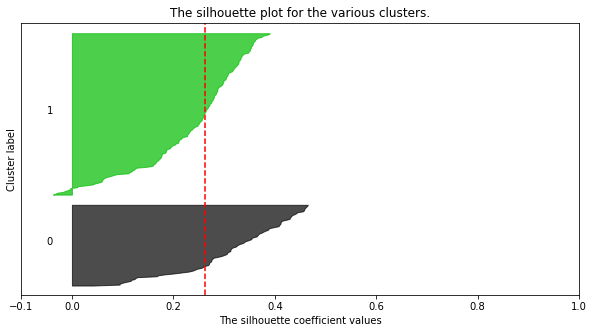

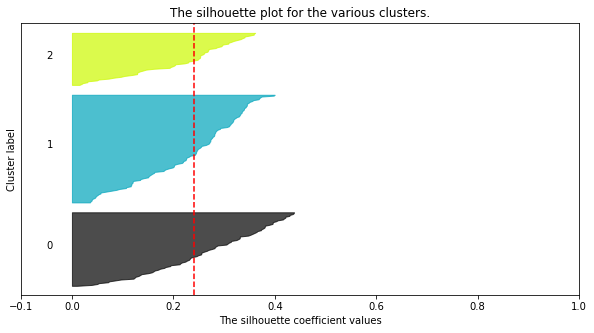

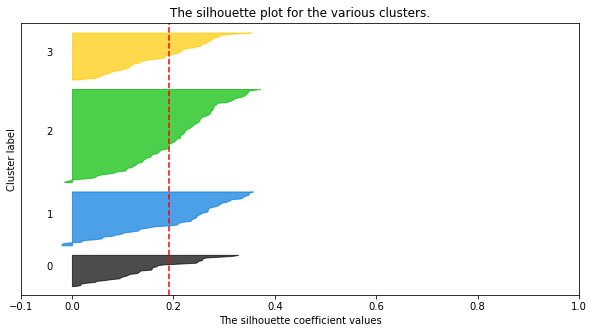

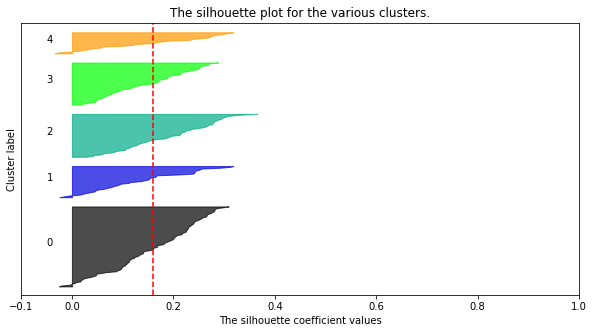

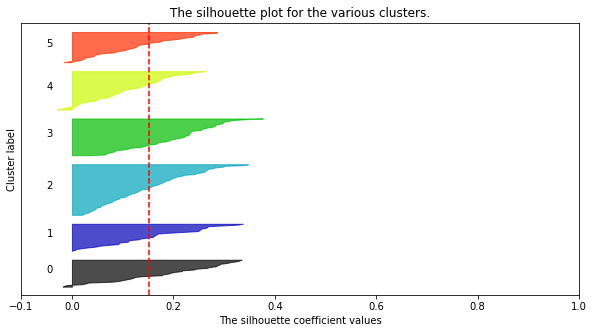

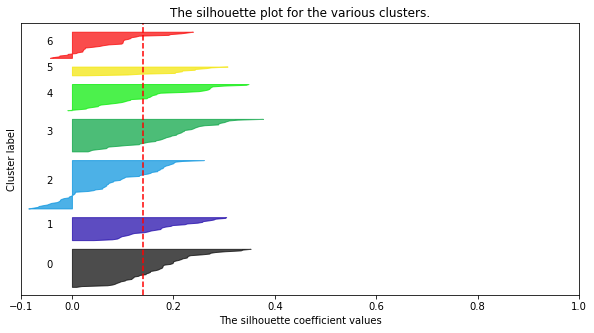

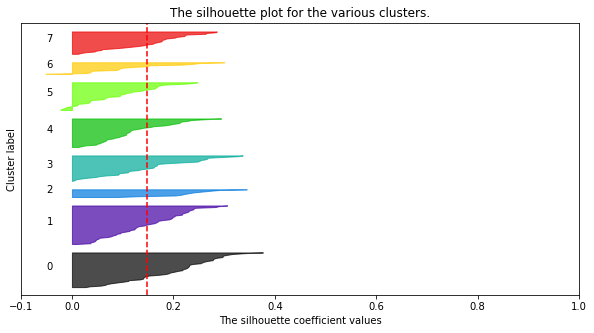

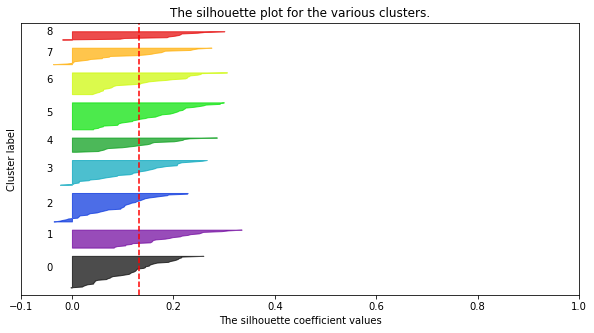

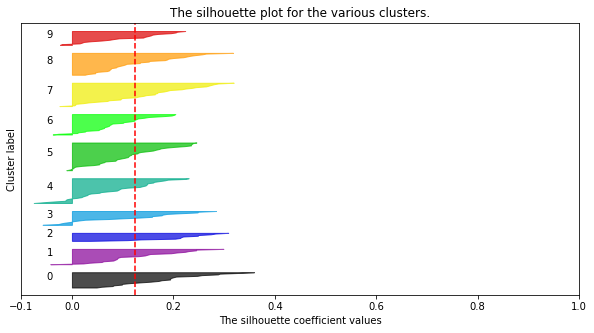

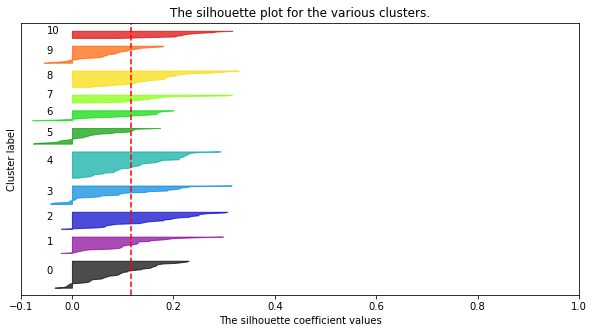

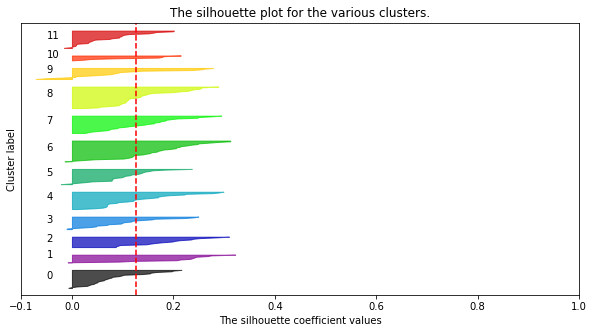

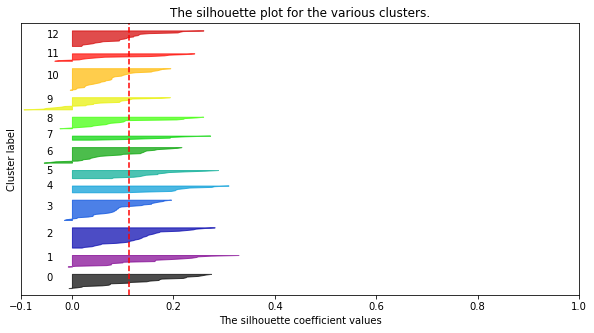

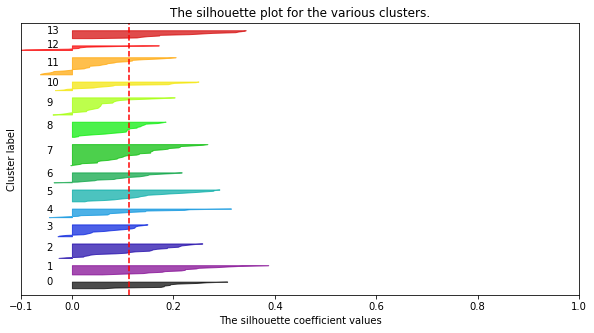

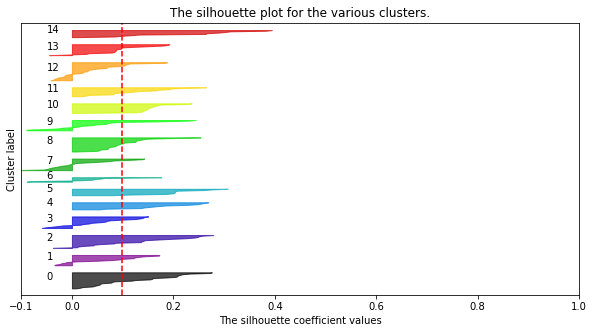

In [1069]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import numpy as np
range_n_clusters = range(2, 16)
labels = {}
for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(10, 5)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(results) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(results)
    labels[n_clusters] = cluster_labels
    silhouette_avg = silhouette_score(results, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(results, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


In [1089]:
#Based on the sillhouette plots and sillhouette scores, 8 or 12 clusters seem to be the best fits for the Data
groups = pd.DataFrame(labels[12], index = results.index).groupby(0)
print(groups.groups)
# for name, group in groups:
#     print(group.join)
# 2 Most common positions in each group


{0: Index(['Andre Iguodala', 'Bogdan Bogdanovic', 'Brandon Ingram', 'Caris LeVert',
       'Delon Wright', 'Devin Harris', 'Dwyane Wade', 'Dwyane Wade',
       'Evan Turner', 'James Johnson', 'Jimmy Butler', 'Joe Ingles',
       'Jordan Clarkson', 'Jordan Clarkson', 'Josh Richardson',
       'Kent Bazemore', 'Khris Middleton', 'Kyle Anderson', 'Lance Stephenson',
       'Malcolm Brogdon', 'Manu Ginobili', 'Nicolas Batum', 'Paul George',
       'Shaun Livingston', 'Tyler Johnson', 'Victor Oladipo', 'Will Barton'],
      dtype='object'), 1: Index(['Alex Len', 'Andre Drummond', 'Bam Adebayo', 'Bismack Biyombo',
       'Clint Capela', 'Dwight Howard', 'Ed Davis', 'Enes Kanter',
       'Ian Mahinmi', 'Mason Plumlee', 'Montrezl Harrell', 'Steven Adams'],
      dtype='object'), 2: Index(['Andrew Wiggins', 'Avery Bradley', 'Bojan Bogdanovic', 'Buddy Hield',
       'Courtney Lee', 'E'Twaun Moore', 'Eric Gordon', 'Evan Fournier',
       'Gary Harris', 'Jamal Crawford', 'Jaylen Brown', 'Jeremy La

for name, group in groups:
    print(group.join(results))